In [2]:
#Copyright 2023 University Of Houston
"""THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES,
INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED.
IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, 
OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS;
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE."""



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans

# # Incremental PCA

In [2]:
def compute_corr(gamma):
    n = gamma[0,0]
    d = len(gamma)
    L = gamma[1:d,0] #[row,column]
    Q = gamma[1:d,1:d]

    corr_matrix = np.zeros([len(Q),len(Q)])

    for i in range(len(Q)):
        denom_1 = math.sqrt((n*Q[i,i]) - (L[i]*L[i]))
        for j in range(len(Q)):
            numerator = ((n*Q[i,j]) - (L[i]*L[j]))
            denom_2 = math.sqrt((n*Q[j,j]) - (L[j]*L[j]))
            corr_matrix[i,j] = numerator/(denom_1*denom_2)
            
    #u, s, vh = np.linalg.svd(corr_matrix)
    return corr_matrix

def compute_PCA(gamma):
    n = gamma[0,0]
    d = len(gamma)
    L = gamma[1:d,0] #[row,column]
    Q = gamma[1:d,1:d]

    corr_matrix = np.zeros([len(Q),len(Q)])

    for i in range(len(Q)):
        denom_1 = math.sqrt((n*Q[i,i]) - (L[i]*L[i]))
        for j in range(len(Q)):
            numerator = ((n*Q[i,j]) - (L[i]*L[j]))
            denom_2 = math.sqrt((n*Q[j,j]) - (L[j]*L[j]))
            corr_matrix[i,j] = numerator/(denom_1*denom_2)
            
    u, s, vh = np.linalg.svd(corr_matrix)
    
    return [u,s,vh]

In [3]:


def compute_gamma(X):
    #print(X.shape)
    ones = [1]*X.shape[1]
    Z = np.vstack([ones,X])
    gamma = np.dot(Z,np.transpose(Z))
    
    
    return gamma
def compute_kmeans(gamma):
    N = []
    L = []
    Q = []
    prior = []
    mu = []
    sigma = []
    gamma = np.transpose(gamma)
    
    Nglobal = 0 #total number of rows
    for i in range(2):
        Nglobal+=gamma[0,i*2]    
    NumDim = np.shape(gamma)[0]-2 #get total dimensions

    #print(Nglobal, NumDim)
    print(gamma)
    for index in range(2):
        N.append(gamma[0,index*2])
        L.append(gamma[1:np.shape(gamma)[0],index*2])
        Q.append(gamma[1:np.shape(gamma)[0],index*2+1])
        
        #print(Q,L)
        
        print("Q and L: ")
        print(Q[index][0:NumDim],L[index][0:NumDim])
        mu.append(L[index][0:NumDim]/N[index]) # C
        sigma.append((Q[index][0:NumDim]/N[index]) - (L[index][0:NumDim]/N[index]**2)) #R
        prior.append(N[index]/Nglobal) # W
        
        

    return [mu, sigma, prior] #CRW
def compute_k_gamma(X, k):
    n = X.shape[0]
    d = X.shape[1]
    class_col = d
    
    X_array = X.to_numpy()
    x = np.zeros(d+1)
    G = np.zeros((k*2,d+1))
    for i in range(0,n):
        c = int(X_array[i,class_col-1]) #getting class number
        #print(c)
        x[0] = 1
        for j in range(0,d):
            x[j+1] = X_array[i,j] #X with extra 1s
        
        for j in range(0,d+1):
            G[c*2,j] += x[j] * x[0]
            if j!=0:
                G[c*2+1,j] += x[j] * x[j]
    return G
def assignCluster(X, cluster_centroids, k):
    cluster_id = [0]*len(X)
    sum_of_error = 0.0
    for i in range (0,len(X)):
        sq_diff_sum = [0]*k
        for j in range(k):
            clu_cent_vector = cluster_centroids[j]
            cluster_centroid_j = clu_cent_vector
            sq_diff_sum[j] = sum((X[i]-cluster_centroid_j)**2) ## X(i,_) -> ?
        
        cluster_id[i] = sq_diff_sum.index(min(sq_diff_sum)) #argmin
        sum_of_error += min(sq_diff_sum)
    ret = [cluster_id,sum_of_error]
    return ret

In [8]:

iteration = 0 
ChunkSize = 500

s_prev = float("inf")
ds = "ch2.csv"
for df in pd.read_csv(ds, chunksize=ChunkSize):
    X = df.to_numpy() #a nXd numpy array
    
    # compute gamma
    if iteration == 0:
        gamma = compute_gamma(np.transpose(X))
    else:
        partial_gamma = compute_gamma(np.transpose(X))
        gamma += partial_gamma
    iteration +=1 
        
    # compute PCA
    pca_model = compute_PCA(gamma)    
    u = pca_model[0]
    s = pca_model[1]
    vh = pca_model[2]
    
    #incremental: stopping earlier
    #if iteration>12 and abs(max(s)-s_prev)<0.001:
     #   break
       # initially smaller chunks 500, later 5000 
    #s_prev = max(s)
        
    
    
#print("u= ", u)
print("Total iteration:", iteration)
print("Eigen values (s)= ",s)
#print("vh=",vh)
## get number of components to be selected (k) 
variance_captured_so_far = []
k = 0 #top k components
for i in range(len(s)):
    variance_captured_so_far.append(sum(s[:i+1])/sum(s))
    print("Component selected:" +str(i) + ", variance_captured_so_far:"+str(variance_captured_so_far[-1]))
    #stop the loop at 90%
    if variance_captured_so_far[-1]>0.9:
        k = i
        break
## select k columns (components) from vh
print("Before vh dimension:",vh.shape)
vh_k = vh[:, :k+1]
vh_k = vh[:, :2]
print("After vh dimension:",vh_k.shape)
#for i in range(len(vh)):

Total iteration: 121
Eigen values (s)=  [1.47622080e+01 8.49402920e+00 5.32055348e+00 2.54600723e+00
 1.86734209e+00 1.81205440e+00 1.46083558e+00 1.28953240e+00
 1.18740393e+00 1.02592582e+00 1.01867216e+00 9.33397566e-01
 7.77397805e-01 7.18111917e-01 5.73722494e-01 5.07683460e-01
 4.21195796e-01 2.71012886e-01 2.26793662e-01 1.69310516e-01
 1.38549128e-01 1.17243919e-01 8.53772546e-02 7.23694913e-02
 4.32571278e-02 3.22966415e-02 2.16221800e-02 2.02894779e-02
 1.43197476e-02 1.25698573e-02 9.01985420e-03 8.38213355e-03
 7.74772281e-03 6.85219475e-03 6.20181276e-03 4.77938213e-03
 4.40202383e-03 2.93123204e-03 2.18543208e-03 1.88180011e-03
 1.42944177e-03 1.02210961e-03 9.30846584e-04 5.18060770e-04
 3.40443564e-04 2.90305039e-04]
Component selected:0, variance_captured_so_far:0.3209175650272654
Component selected:1, variance_captured_so_far:0.5055703738221545
Component selected:2, variance_captured_so_far:0.6212345798864515
Component selected:3, variance_captured_so_far:0.6765825631

In [9]:
##get the final matrix with K-dimensions
df_original = pd.read_csv(ds)
X_k = np.dot(df_original.to_numpy(),vh_k)
print("new dimension of the dataset:",X_k.shape)
df_k = pd.DataFrame(X_k)
#df_k.to_csv(f"{ds}_reducted.csv",index=False)
df_cluster_vis = df_k
df_cluster_vis.shape
tmp = df_k

new dimension of the dataset: (60137, 2)


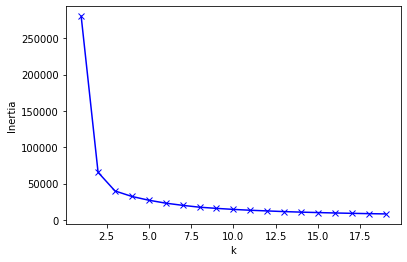

In [10]:


 
inertia = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_cluster_vis)
    #kmeanModel.fit(df_cluster_vis)
    inertia.append(kmeanModel.inertia_)
    
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()
    
#df_cluster_vis["label"] = pd.DataFrame(label)
#print(label)

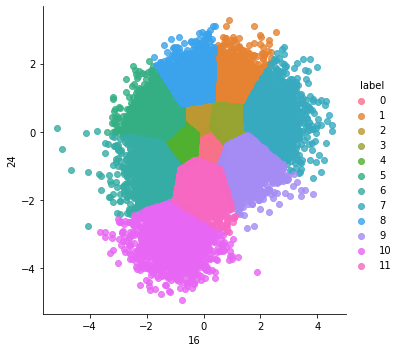

In [13]:
import seaborn as sns
ds = "ch2.csv"
df_var_k = pd.read_csv(ds)
cols = ["16","24"]
df_var_k = df_var_k[cols]
tmp = df_var_k
#df_var_k.columns = ["32","42"]
kmeans = KMeans(n_clusters=12).fit(df_var_k)
tmp["label"] = pd.DataFrame(kmeans.labels_)
sns.lmplot(x=cols[0],y=cols[1],data=tmp,hue='label',fit_reg=False)

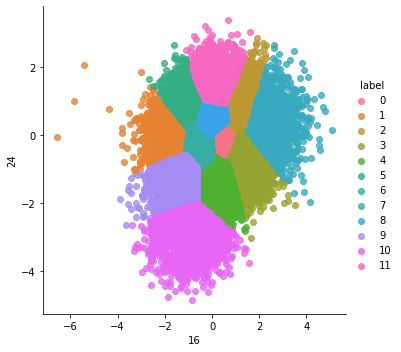

In [14]:
ds = "ch3.csv"

import seaborn as sns
df_var_k = pd.read_csv(ds)
cols = ["16","24"]
df_var_k = df_var_k[cols]
tmp = df_var_k
#df_var_k.columns = ["32","42"]
kmeans = KMeans(n_clusters=12).fit(df_var_k)
tmp["label"] = pd.DataFrame(kmeans.labels_)
sns.lmplot(x=cols[0],y=cols[1],data=tmp,hue='label',fit_reg=False)

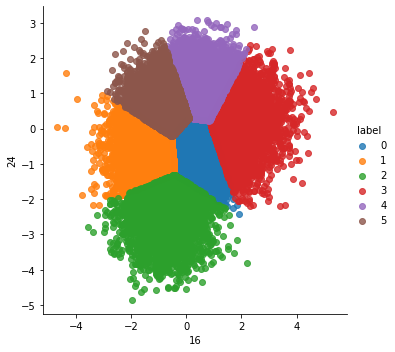

In [18]:
ds = "ch4.csv"

import seaborn as sns
df_var_k = pd.read_csv(ds)
cols = ["16","24"]
df_var_k = df_var_k[cols]
tmp = df_var_k
#df_var_k.columns = ["32","42"]
kmeans = KMeans(n_clusters=6).fit(df_var_k)
tmp["label"] = pd.DataFrame(kmeans.labels_)
sns.lmplot(x=cols[0],y=cols[1],data=tmp,hue='label',fit_reg=False)


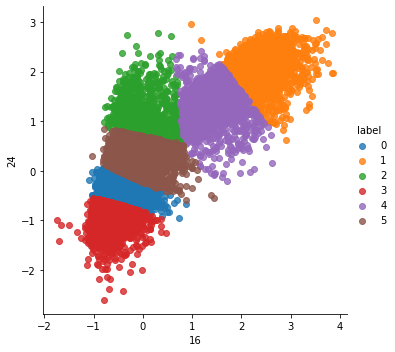

In [16]:
ds = "ch5.csv"

import seaborn as sns
df_var_k = pd.read_csv(ds)
cols = ["16","24"]
df_var_k = df_var_k[cols]
tmp = df_var_k
#df_var_k.columns = ["32","42"]
kmeans = KMeans(n_clusters=6).fit(df_var_k)
tmp["label"] = pd.DataFrame(kmeans.labels_)
sns.lmplot(x=cols[0],y=cols[1],data=tmp,hue='label',fit_reg=False)